# qTPU Basics

In this brief tutorial we go through the process of 
1. compiling a large quantum circuit into an efficient `hybrid tensor network`, consisting of classical- and smaller quantum-tensors, and
2. contracting a hybrid tensor network using both classical and quantum devices to obtain the result of the circuit.

In [1]:
import numpy as np
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from IPython.display import display
import qtpu

We start by creating a random ansatz with linear entanglement:

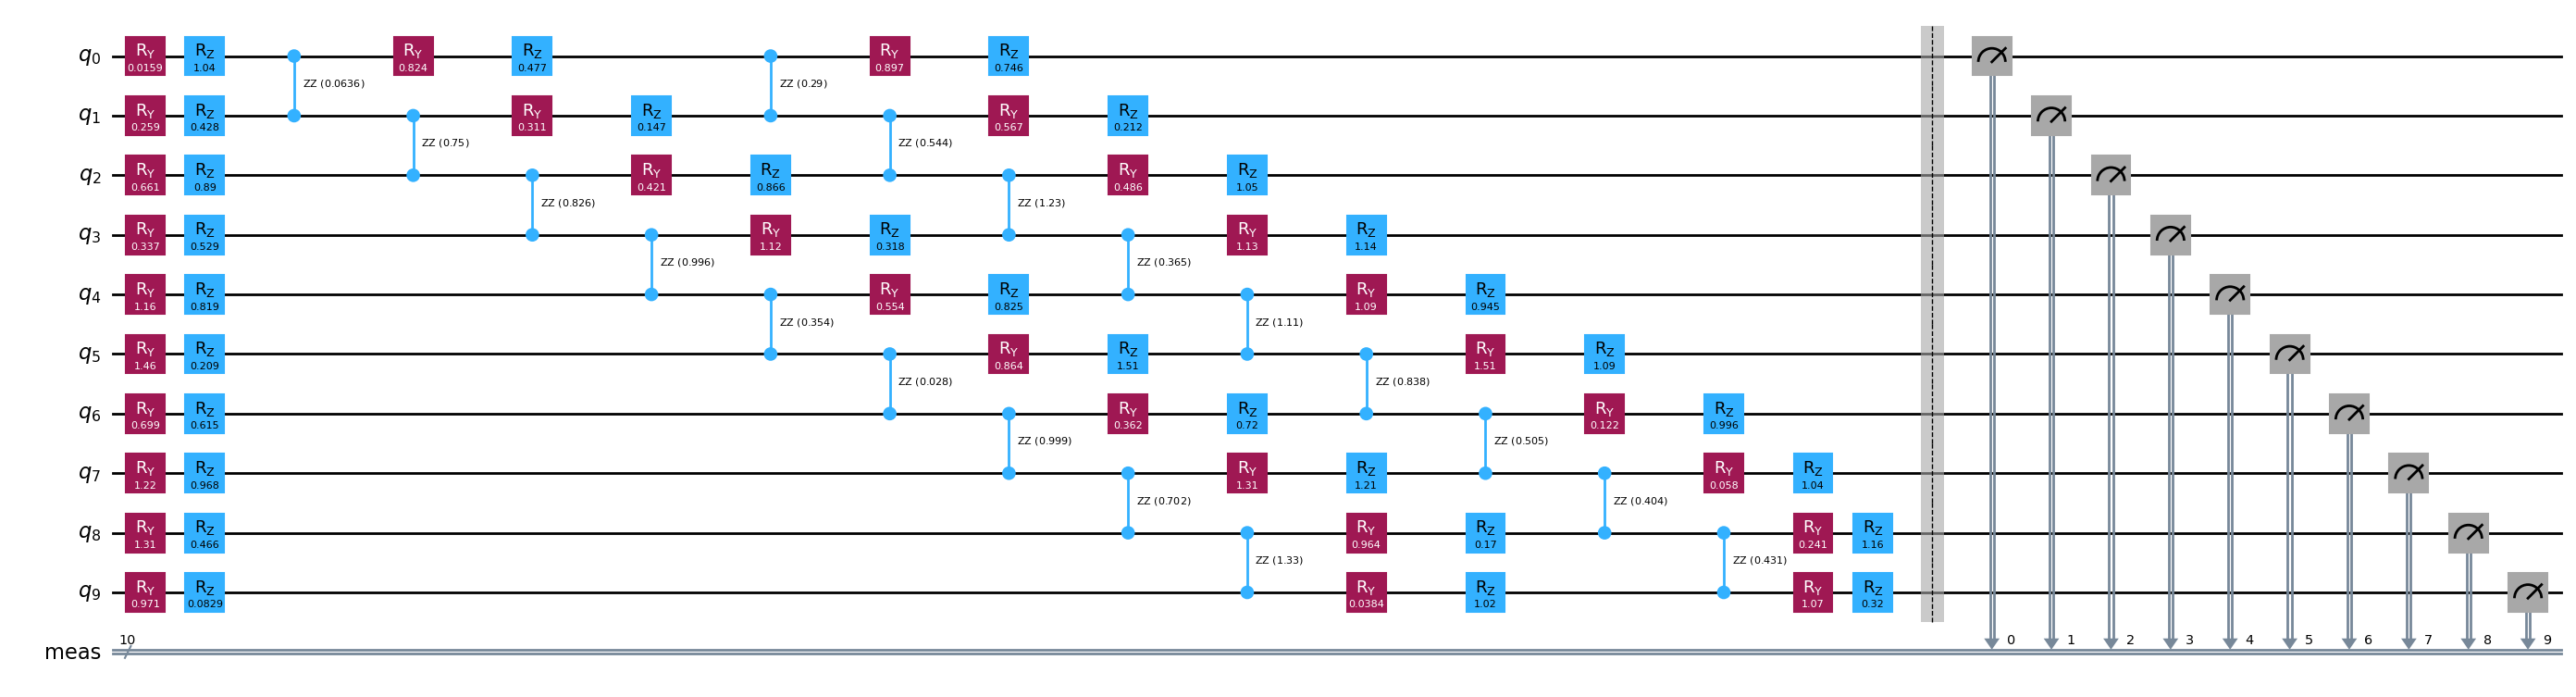

In [2]:
N = 10
circuit = TwoLocal(N, ["ry", "rz"], "rzz", entanglement="linear", reps=2).decompose()
circuit = circuit.assign_parameters(
    {param: np.random.rand() * np.pi / 2 for param in circuit.parameters}
)
# circuit = QuantumCircuit(N)
# circuit.h(0)
# circuit.cx(range(0, N-1), range(1, N))
# circuit.measure_all()

from qiskit.circuit.random import random_circuit

# circuit = random_circuit(7, 15, max_operands=2, seed=1242)

# from qiskit.circuit import ClassicalRegister
# circuit.add_register(ClassicalRegister(3))
# circuit.measure(range(2, 5), range(3))

circuit.measure_all()

circuit.draw("mpl", fold=-1)

## Compiling (cutting) the circuit

To compile the circuit into an efficient hybrid tensor network, we can use the `qtpu.cut` function. This function uses hyperparameter-optimization to find a good partitioning of the circuit, and then creates a hybrid TN of the partitioned circuit.
In this case, we use the terminator `reach_num_qubits(N//2)` to specify that we want the quantum-tensors to use at most `N/2` qubits.

In [3]:
from qtpu.helpers import expval_quimb
cc = circuit.copy()
cc.remove_final_measurements()
expval_quimb(cc)

0.005052964457675283

  0%|          | 0/50 [00:00<?, ?it/s]

[3851.    6. 3851. 3851. 3851.  168.  726. 3851. 3851. 3851.   12.    6.
    6. 3851.  600. 3851. 3851. 3851.    6.]
True


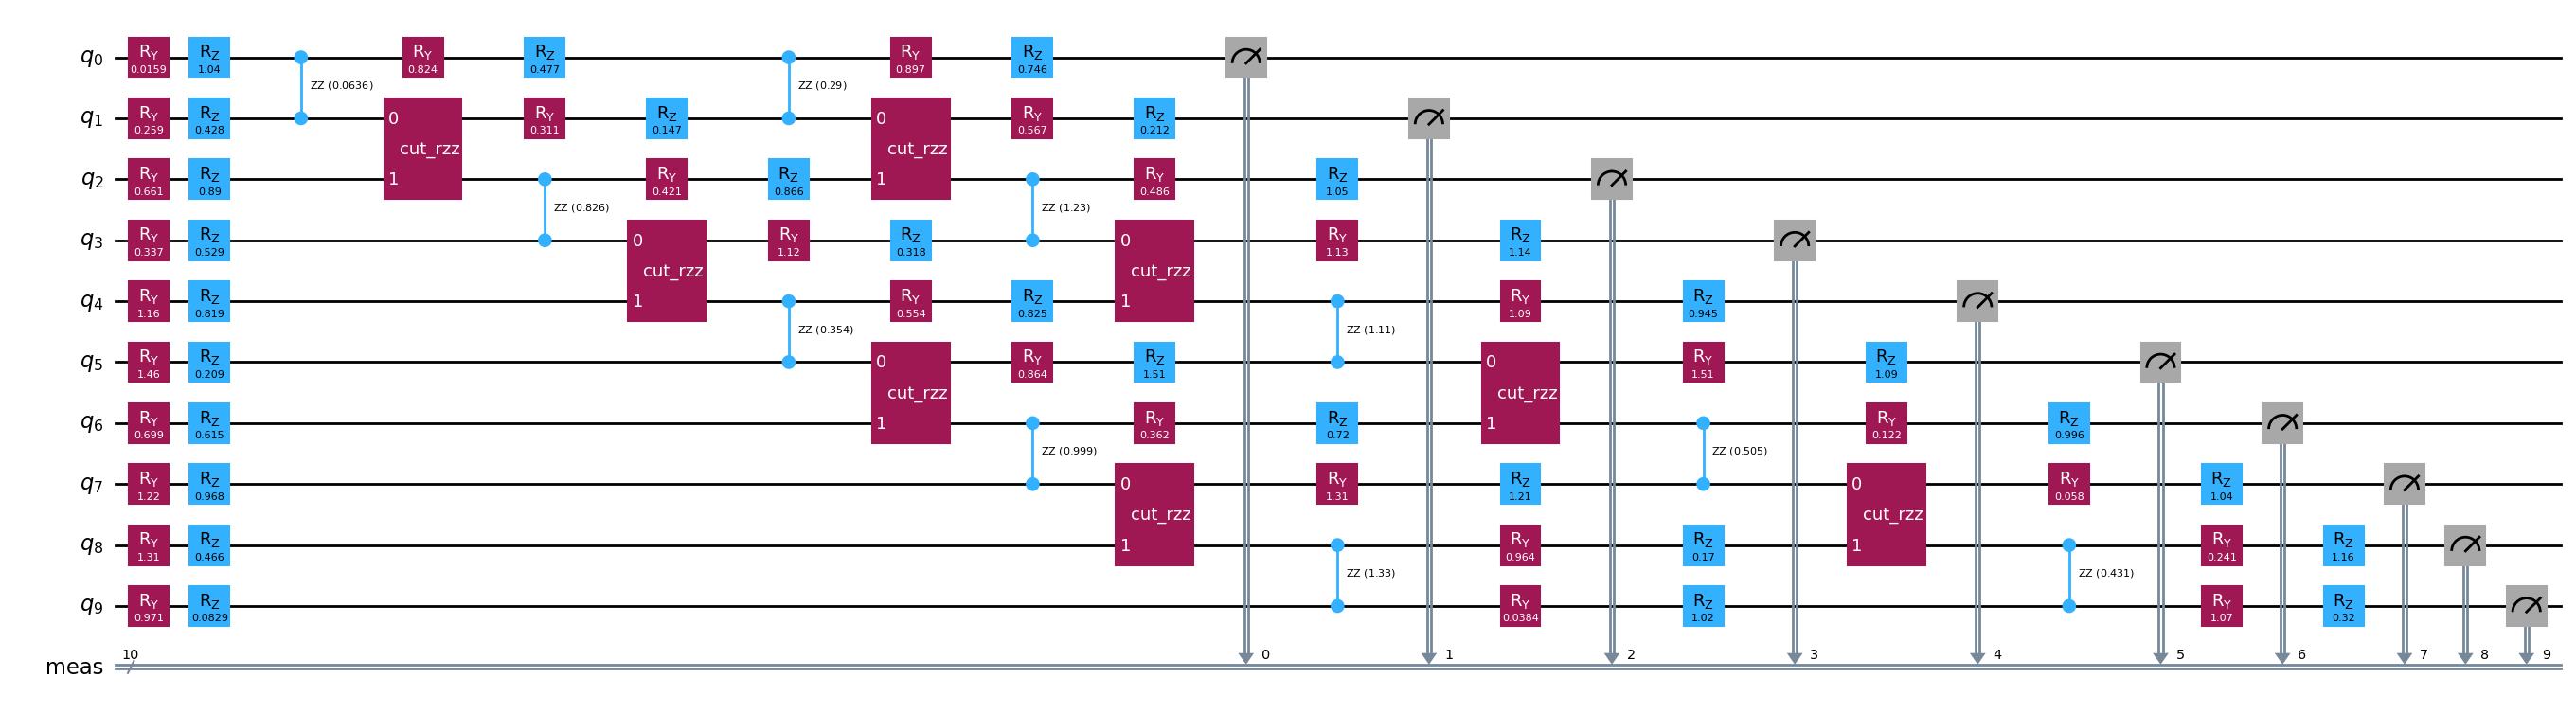

In [4]:
from qtpu.compiler.terminators import reach_num_qubits

cut_circuit = qtpu.cut(
    circuit,
    terminate_fn=reach_num_qubits(6),
    max_cost=100000,
    compression_methods=["qubits"],
    show_progress_bar=True,
    n_trials=50,
)
cut_circuit.draw("mpl", fold=-1)

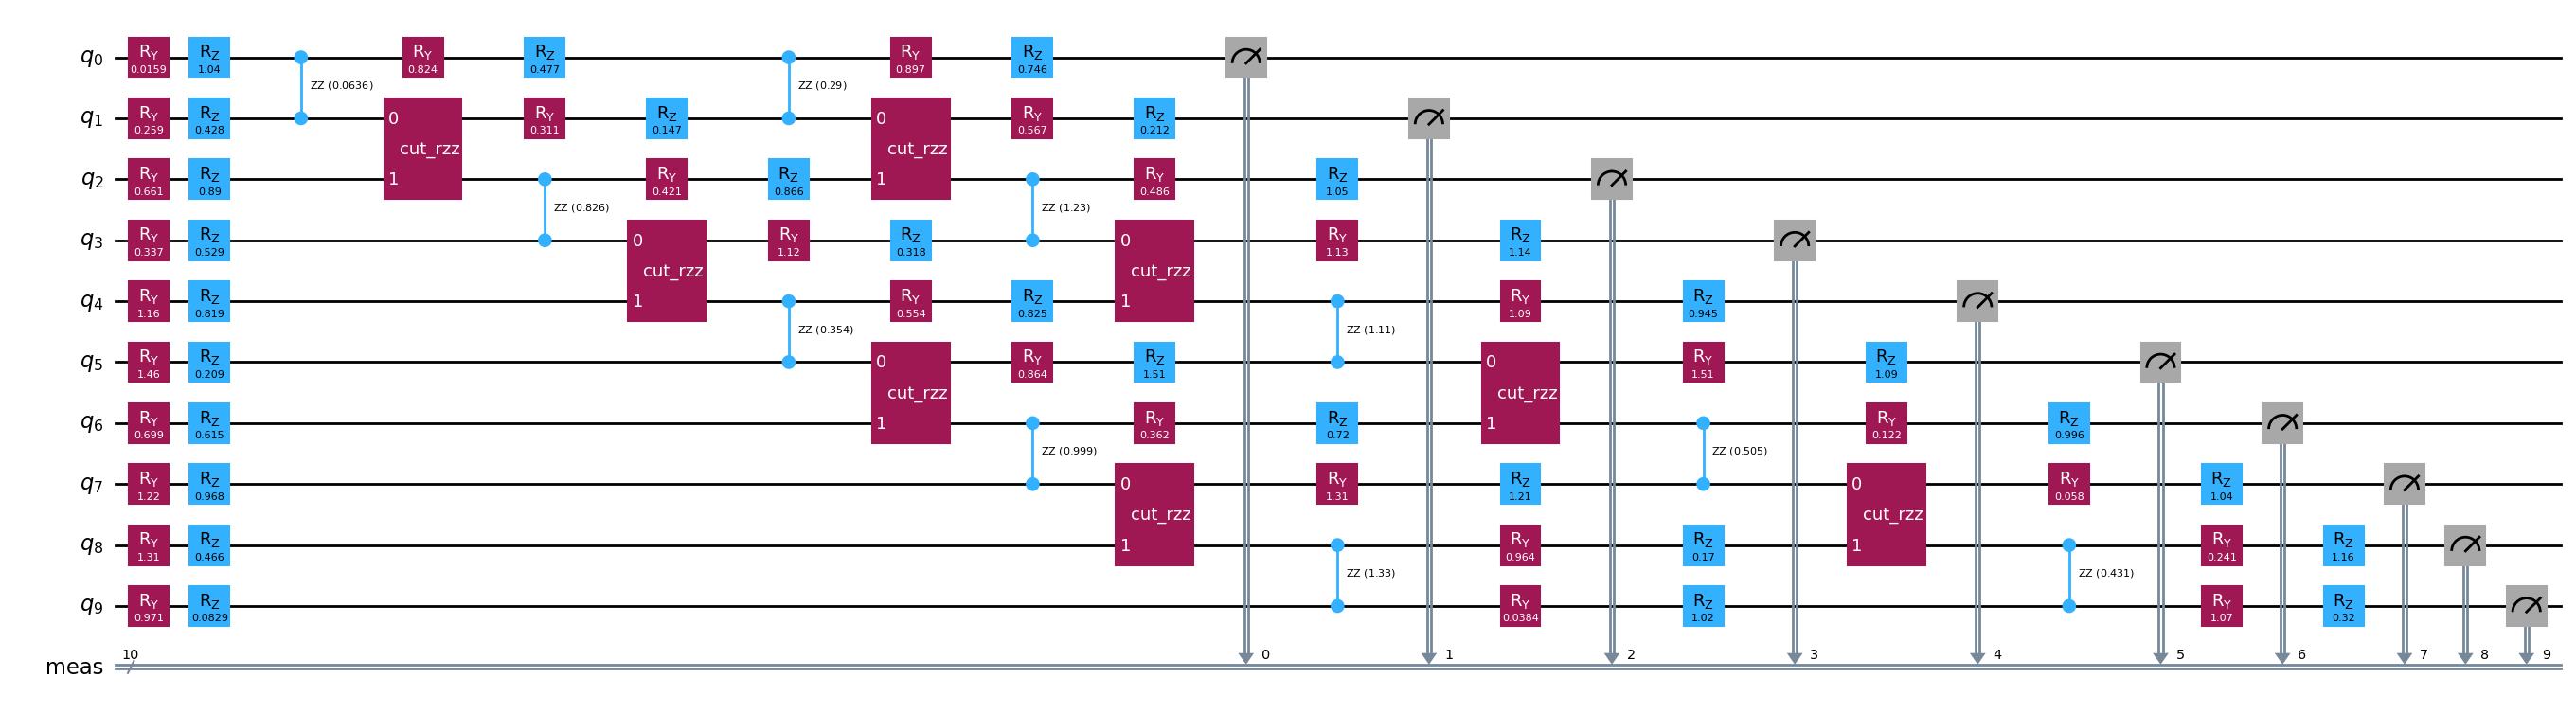

In [5]:
from qtpu.circuit import circuit_to_hybrid_tn, cuts_to_moves


cut_circuit = cuts_to_moves(cut_circuit)

# cut_circuit = wire_cuts_to_move(cut_circuit)

cut_circuit.draw('mpl', fold=-1)    
# print(htn)

# htn.quimb_tn().draw()

# from qtpu.contract2 import contract

# contract(htn)

In [6]:
# from benchmark.ckt import run_ckt
# from qiskit_aer.primitives import Sampler

# ckt_circ = cut_circuit.copy()
# ckt_circ.remove_final_measurements()
# result = run_ckt(ckt_circ, Sampler(), num_samples=np.inf, obs="ZZIZII")
# print(result)

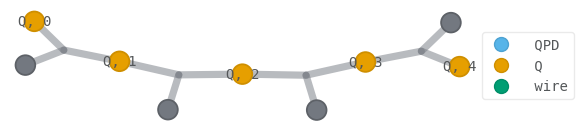

4068


In [7]:
htn = circuit_to_hybrid_tn(cut_circuit)
# htn.approximate(tolerance=0.1)
# htn.sample(1000)
# fuse(htn)
# approximate(htn, tolerance=0.01)
tn = htn.to_tensor_network()
tn.draw(color=["QPD", "Q", "wire"])
print(tn.contraction_cost(optimize='auto'))

In [13]:
from qtpu.contract import contract, evaluate_hybrid_tn

# from qtpu.evaluate import evaluate_backend
from qiskit_aer.primitives import Sampler

# backend = AerSimulator()


from qiskit.primitives import BackendSampler

res = contract(htn, Sampler(run_options={"shots": 20000}))

# tn = evaluate_hybrid_tn(htn)

# print()

# res = tn.contract(all, optimize='auto', output_inds=[])


Evaluating 3960 circuits


In [14]:
from qiskit.primitives import Sampler, Estimator

# ref_samples = Sampler().run(circuit, shots=10000000).result().quasi_dists[0]

ref_circ = circuit.copy()
ref_circ.remove_final_measurements()
ref_expval = Estimator().run(ref_circ, ["Z" * N]).result().values[0]

print("Fidelities:")
print(ref_expval, res)
# print(hellinger_fidelity(ref_samples, res.nearest_probability_distribution()))

Fidelities:
0.005052964457675369 {231: 6.52298288050342e-05, 239: 2.5838667714244517e-05, 235: 0.00042184501434871125, 227: 0.0006912327560893107, 229: 0.00040316498177553323, 237: 6.06790819649678e-06, 233: 0.0019138973417606965, 225: 0.0030070310671807435, 228: 0.0004186755470757664, 236: 1.7972434656167365e-05, 232: 0.002098380895561776, 224: 0.003334838954685806, 230: 6.336910781449503e-05, 238: 1.0555193251857504e-05, 234: 0.0002823593653713543, 226: 0.00043149530179310543, 247: 9.021721157509287e-05, 255: 0.00010501571778113455, 251: 0.0002329446975343608, 243: 0.00035835988019549216, 245: 0.0003023507551117762, 253: 4.57715382100391e-05, 249: 0.0012774702792326571, 241: 0.001766600910688656, 244: 0.0003223522652744649, 252: 6.50099702110858e-05, 248: 0.001385147411682867, 240: 0.001954615222605232, 246: 7.464469696817476e-05, 254: 7.24745885459724e-05, 250: 0.00016319739185311497, 242: 0.0002185852724821603, 215: 9.19716622696904e-05, 223: 0.00012452417608774659, 219: 0.00052153

In [15]:
from qiskit.primitives import Sampler, Estimator
from qiskit.quantum_info import hellinger_fidelity

ref_samples = Sampler().run(circuit, shots=1000000).result().quasi_dists[0]

ref_circ = circuit.copy()
ref_circ.remove_final_measurements()
ref_expval = Estimator().run(ref_circ, ["Z" * N]).result().values[0]

print("Fidelities:")
print(ref_expval, res)
print(hellinger_fidelity(ref_samples, res.nearest_probability_distribution()))
# print(1 - abs(ref_expval - result_exp))

Fidelities:
0.005052964457675369 {231: 6.52298288050342e-05, 239: 2.5838667714244517e-05, 235: 0.00042184501434871125, 227: 0.0006912327560893107, 229: 0.00040316498177553323, 237: 6.06790819649678e-06, 233: 0.0019138973417606965, 225: 0.0030070310671807435, 228: 0.0004186755470757664, 236: 1.7972434656167365e-05, 232: 0.002098380895561776, 224: 0.003334838954685806, 230: 6.336910781449503e-05, 238: 1.0555193251857504e-05, 234: 0.0002823593653713543, 226: 0.00043149530179310543, 247: 9.021721157509287e-05, 255: 0.00010501571778113455, 251: 0.0002329446975343608, 243: 0.00035835988019549216, 245: 0.0003023507551117762, 253: 4.57715382100391e-05, 249: 0.0012774702792326571, 241: 0.001766600910688656, 244: 0.0003223522652744649, 252: 6.50099702110858e-05, 248: 0.001385147411682867, 240: 0.001954615222605232, 246: 7.464469696817476e-05, 254: 7.24745885459724e-05, 250: 0.00016319739185311497, 242: 0.0002185852724821603, 215: 9.19716622696904e-05, 223: 0.00012452417608774659, 219: 0.00052153